In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [19]:
# Below is the Data loader method for loading training and testing datasets
def load_data(train_batch, test_batch):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((64, 64)),
                           transforms.ToTensor()
                       ])),
        batch_size=train_batch, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])),
        batch_size=test_batch, shuffle=True)

    return train_loader, test_loader

In [20]:
# Below is the model definition using convolutional and linear layers
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.layer1 = nn.Conv2d(1, 6, kernel_size=5)
        self.layer2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.layer1(x)), 2)
        x = F.max_pool2d(F.relu(self.layer2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# Below is the function to compute sensitivity of the model gradients
def compute_gradient_sensitivity(model):
    total_norm = 0
    num_params = 0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm = torch.linalg.norm(param.grad).item()
            total_norm += grad_norm
            num_params += 1
    return total_norm / num_params if num_params > 0 else 0

In [22]:
#Initializing the optimizer
def configure_optimizer(model):
    return optim.SGD(model.parameters(), lr=1e-2)

In [23]:
# We are training loop for a single epoch
def train_epoch(model, optimizer, train_loader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

In [24]:
# Below is the function to evaluate model performance on a dataset
def evaluate_model(model, data_loader):
    correct_preds = 0
    total_preds = 0
    loss_sum = 0
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            loss = loss_fn(output, target)
            loss_sum += loss.item()
            preds = torch.argmax(output, dim=1)
            correct_preds += (preds == target).sum().item()
            total_preds += target.size(0)
    return loss_sum / len(data_loader), correct_preds / total_preds

In [25]:
# Hyperparameters and metric storage
epoch_count = 50
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
sensitivity_values = []

# Below is the main training loop for multiple epochs
def train_and_evaluate(model, optimizer, train_loader, test_loader):
    print("Starting training...")
    for epoch in range(1, epoch_count + 1):
        print(f'Epoch {epoch}/{epoch_count}')
        train_epoch(model, optimizer, train_loader)
    train_loss, train_acc = evaluate_model(model, train_loader)
    test_loss, test_acc = evaluate_model(model, test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

In [26]:
#Experiment with different batch sizes
batch_sizes = [32, 64, 128, 256, 512]
for batch_size in batch_sizes:
    train_loader, test_loader = load_data(batch_size, batch_size)
    model = CNNModel()
    optimizer = configure_optimizer(model)
    train_and_evaluate(model, optimizer, train_loader, test_loader)
    sensitivity_values.append(compute_gradient_sensitivity(model))

Starting training...
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Test Loss: 0.05592327721267734, Test Accuracy: 0.9892
Starting training...
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/5

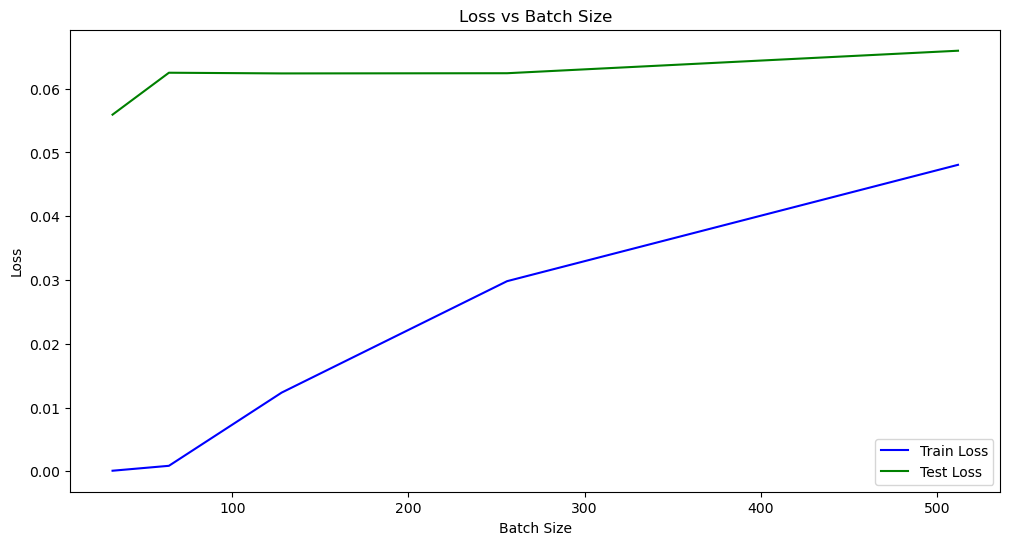

In [27]:
# Plotting loss vs batch size
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, train_losses, color='blue', label='Train Loss')
plt.plot(batch_sizes, test_losses, color='green', label='Test Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.title('Loss vs Batch Size')
plt.legend()
plt.show()

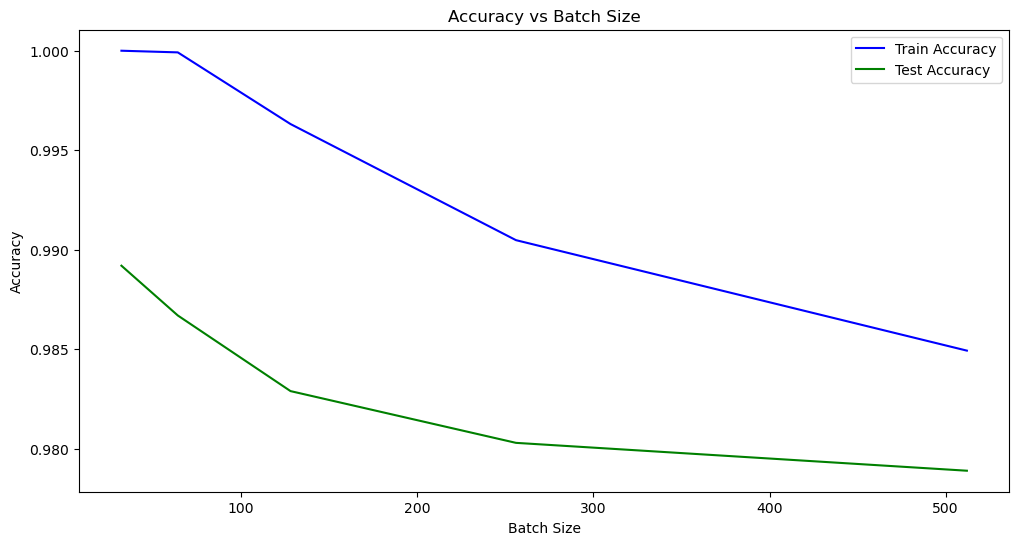

In [28]:
# Plotting accuracy vs batch size
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, train_accuracies, color='blue', label='Train Accuracy')
plt.plot(batch_sizes, test_accuracies, color='green', label='Test Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')
plt.legend()
plt.show()

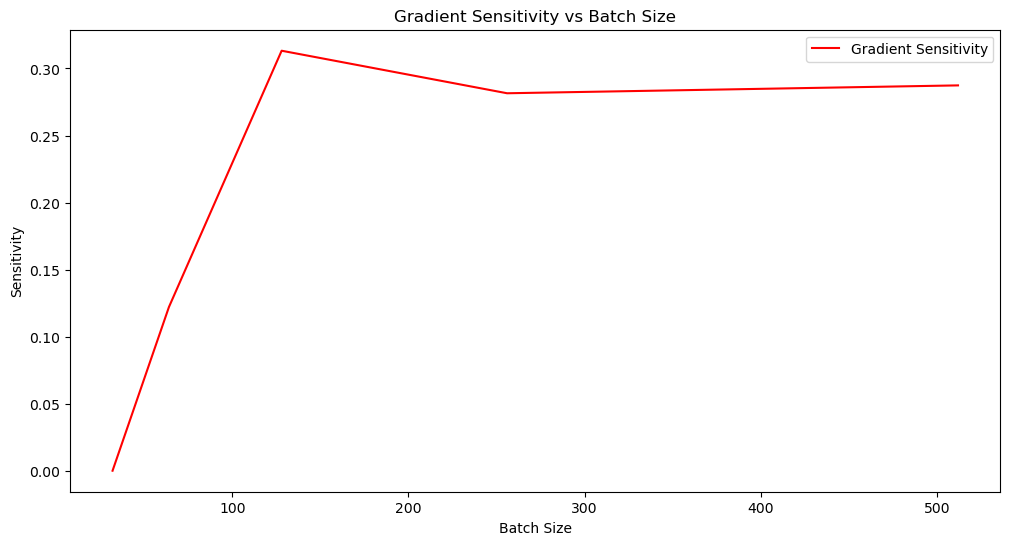

In [29]:
# Plotting sensitivity
plt.figure(figsize=(12, 6))
plt.plot(batch_sizes, sensitivity_values, color='red', label='Gradient Sensitivity')
plt.xlabel('Batch Size')
plt.ylabel('Sensitivity')
plt.title('Gradient Sensitivity vs Batch Size')
plt.legend()
plt.show()